In [1]:
# Imports and basic setup
### UNCOMMENT THE CORRECT ONE
# If you are using Jupyter Lab
# %matplotlib widget

# If you are using Jupyter Notebook
%matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 40})
import pandas as pd
import numpy as np

In [2]:
from scipy import signal

## Ex 10.1: Pan-Tompkins 2 - Combining the filters and correcting shifts
In last exercise we implemented all filter stages of the Pan-Tompkins algorithm.
Now we want to combine them to easily apply the algorithm to multiple signals.

a) Create a function that applies all filter stages of the Pan Tompkins one after the other.

b) Look at the lecture (or the paper from Pan and Tompkins) and look up the delay of each individual filter stage.
Implement a correction for this shift into your filter function. Verify the result using one of the example data files.

Note, that the Pan-Tompkins Algorithm does **not** correct the group-delay of the final MA-filter (half the window size).
It is implicitly considered in the way the output is interpreted.

### Solution:

b) From the paper we learn the following values:

| Filter    | Delay       |
|:----------|:------------|
| Lowpass   | 6 samples   |
| Highpass  | 16 samples  |
| Derivative| 2 samples   |
| Overall   | 24 samples  |

Note, that in the lecture and some books, the lowpass filter is described as haven a 5 sample delay instead of 6.
I don't know the reason for that, but it shouldn't change the output all to much.
So if you used 5 sample, you should still get the same result.



In [3]:
def pan_tompkins(ecg_signal):
    # Filter the signal (200 Hz) with all filter stages of the pan-tompkins.
    # Take the filter parameter we calculated in the last exercise
    
    SAMPLING_RATE = 200.  # Hz
    
    ### BEGIN SOLUTION
    # Set up as and bs
    b_lowpass = np.zeros([13])
    b_lowpass[0] = 1. / 32
    b_lowpass[6] = -2. / 32
    b_lowpass[12] = 1. / 32

    a_lowpass = np.zeros([13])
    a_lowpass[0] = 1.0
    a_lowpass[1] = -2.0
    a_lowpass[2] = 1.0
    
    a_highpass = np.zeros([33])
    a_highpass[0] = 1
    a_highpass[1] = -1

    b_highpass = np.zeros([33])
    b_highpass[0] = -1 / 32
    b_highpass[16] = 1
    b_highpass[17] = -1
    b_highpass[32] = 1 / 32
    
    a_diff = np.array([1, 0, 0, 0, 0])
    b_diff = np.array([1./4, 1./8, 0, -1./8, -1./4])
    
    a_int = np.zeros(30)
    a_int[0] = 1
    b_int = np.ones(30) * 1/30
    
    # Filter the signal
    ecg_signal = signal.lfilter(b_lowpass, a_lowpass, ecg_signal)
    ecg_signal = signal.lfilter(b_highpass, a_highpass, ecg_signal)
    ecg_signal = signal.lfilter(b_diff, a_diff, ecg_signal)
    ecg_signal = ecg_signal ** 2
    ecg_signal = signal.lfilter(b_int, a_int, ecg_signal)
    ### END SOLUTION
    
    # Correct the group delay by removing the correct amount of samples from the beginning of the output
    # Pad the same number of zeros at the end to keep the length identical
    ### BEGIN SOLUTION
    ecg_signal = ecg_signal[24:]
    ecg_signal = np.pad(ecg_signal, (0, 24), constant_values=0)
    ### END SOLUTION
    
    return ecg_signal

In [4]:
def load_data_file(path):
    """Load an example ecg file.
    
    Args:
        path: Path to the example .csv file
        
    Returns:
        time-array in seconds
        ecg signal
    """
    orig_sampling_rate = 256.  # Hz
    pan_sampling_rate = 200.  # Hz
    ecg = pd.read_csv(path, header=1, skiprows=0, index_col='timestamp')['ecg']

    # resample the data to 200 Hz for the algorithms
    ecg = pd.Series(signal.resample(ecg, int(len(ecg) * pan_sampling_rate/orig_sampling_rate)))
    
    # Cut the first 5 seconds to avoid artifacts in this region
    ecg = ecg.iloc[int(5*pan_sampling_rate):].reset_index(drop=True)
    
    ecg.index /= pan_sampling_rate
    
    return ecg.index.values, ecg.values

<IPython.core.display.Javascript object>


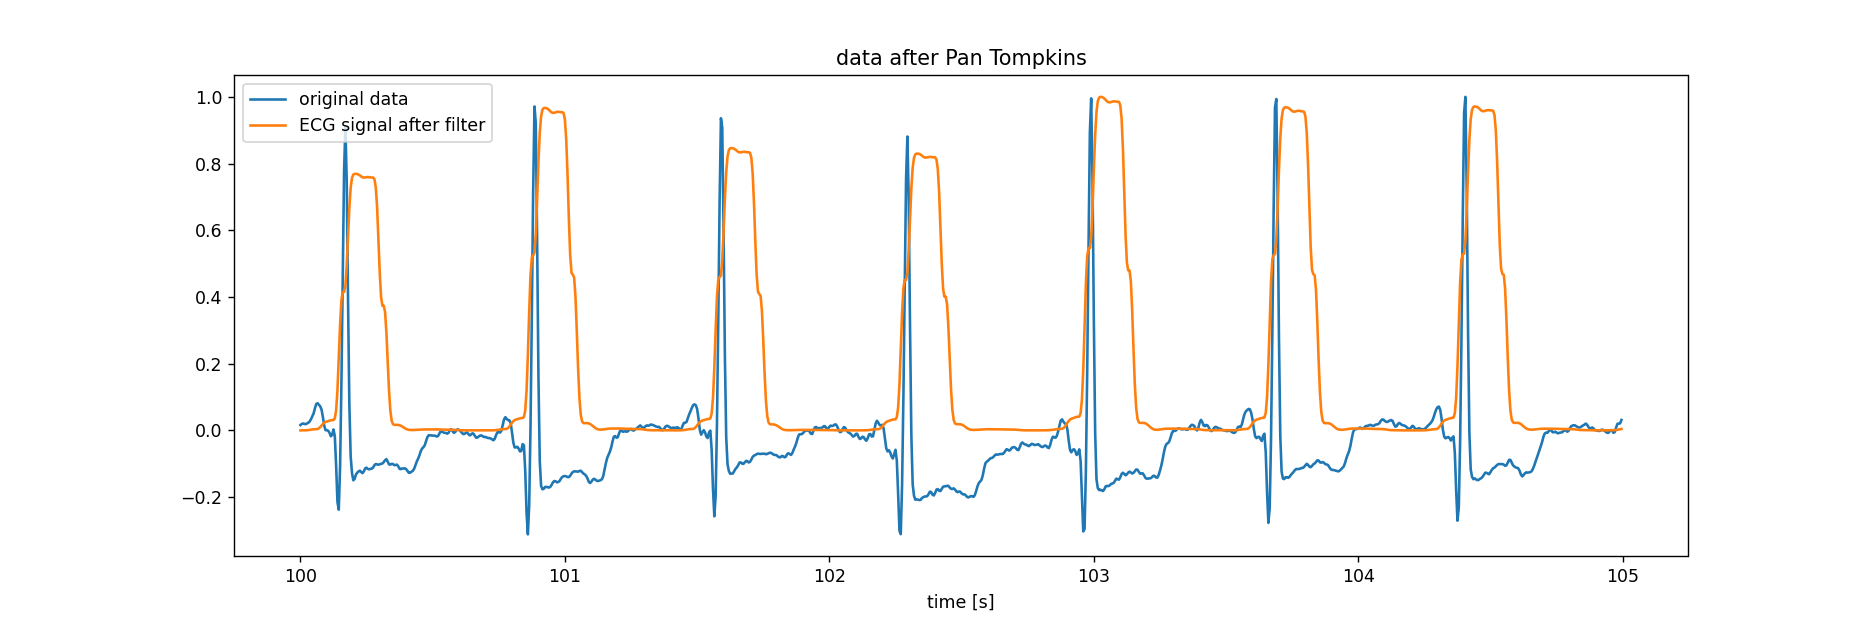

In [5]:
from pathlib import Path

# Use the load_data_file function above to test the pan-tompkins
### BEGIN SOLUTION
path = Path('./data/NilsPodX-9433_20191111_1039.csv')
test_time, test_signal = load_data_file(path)
filtered_signal = pan_tompkins(test_signal)

plt.figure(figsize=(15, 5))
plot_region = slice(100*200, 105*200)
plt.plot(test_time[plot_region], test_signal[plot_region]/test_signal[plot_region].max(), label='original data')
plt.plot(test_time[plot_region], filtered_signal[plot_region]/filtered_signal[plot_region].max(), label='ECG signal after filter')
plt.title('data after Pan Tompkins')
plt.xlabel('time [s]')
plt.legend();
### END SOLUTION

## Ex 10.2: Pan-Tompkins 3 - Search strategy

After the signal is filtered, the Pan-Tomkins algorithm uses multiple adaptable thresholds to detect the now visible QRS-equivalent blocks.
For the sake of simplicity, we will use simple peak detection instead:

a) Have a look at multiple example files and decide on a suitable threshold that should include ideally all QRS-equivalent blocks.

b) Based on your knowledge of the physiological heart-rate of a human, calculate a lower limit for the peak-to-peak distance of two neighboring heartbeats.

c) Use scipy’s `find_peaks` function with both thresholds to detect QRS-Complexes. Validate your results at least on one additional dataset, you did not look at before.

### Solution:

a) 40000 seems to a be suitable value. Note, that this is specific to our dataset and sensors.

b) Assuming a maximal heart-rate of 140bpm (2.33 bps) the minimal expected distance between 2 R peaks is: $1 s/2.33 = 0.42s \approx 400 ms$. $400 ms$ is equivalent to 80 samples.

<IPython.core.display.Javascript object>


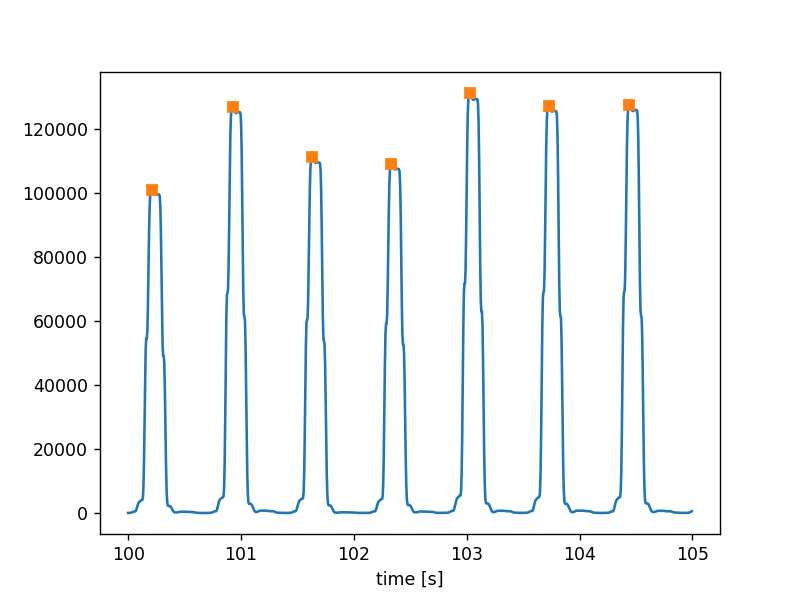

In [6]:
# Create a function that finds the indivdual QRS-complexe in the output of the Pan Tompkins
### BEGIN SOLUTION
MIN_HEIGHT = 40000
MIN_DISTANCE = 80

def find_r_peaks(pan_tom_out):
    return signal.find_peaks(pan_tom_out, height=MIN_HEIGHT, distance=MIN_DISTANCE)[0]
### END SOLUTION

# Test your function by plotting the results together with the raw pan tompkins output.
### BEGIN SOLUTION
r_peaks = find_r_peaks(filtered_signal[plot_region])

plt.figure()
plt.plot(test_time[plot_region], filtered_signal[plot_region])
plt.plot(test_time[plot_region.start + r_peaks], filtered_signal[plot_region.start + r_peaks], 's')
plt.xlabel('time [s]');
### END SOLUTION

## Ex 10.3: Pan-Tompkins - Application 1: Heart rate

With all QRS complexes detected we can directly calculate the heart rate.

a) Calculate the heart-rate based on the R-R distances calculated in the previous step. Do **not** calculate the average heart-rate, but one value per R-R-Interval.

In [7]:
# Create a function that can calculate the heartrate based on the series of detected heartrates
def freq_from_peaks(peaks, sampling_rate):
    """Calculate the frequency of events based on a list of occurrences.
    
    Args:
        peaks: list of indices at which the event occurs
        sampling_rate: sampling rate of the signal to transform the frequency to Hz
        
    Returns:
        heartrate per sample (Hz)
    """
    peaks = peaks.astype(float) # This prevents errors in the following lines
    ### BEGIN SOLUTION
    distances = np.diff(peaks)
    distances /= sampling_rate
    freq = 1. / distances
    ### END SOLUTION
    return freq

<IPython.core.display.Javascript object>


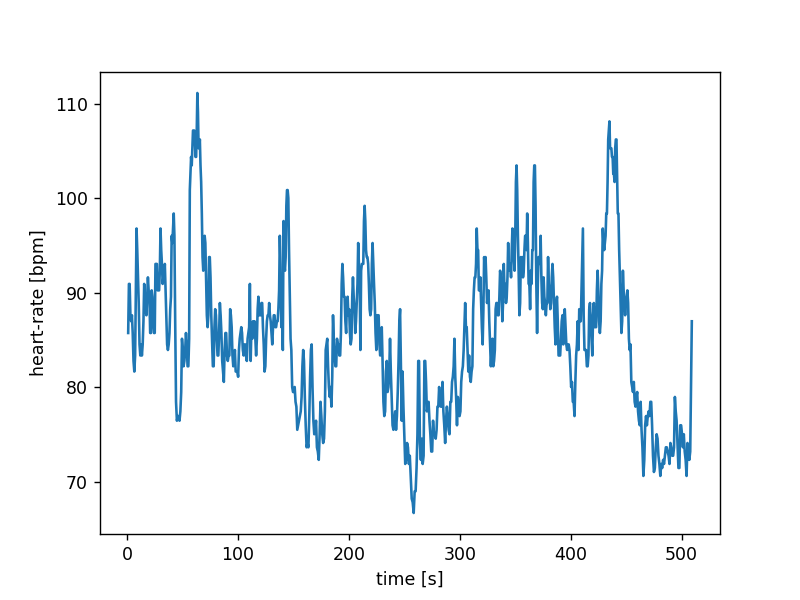

In [8]:
# Plot the heart-rate over the entire duration of recording
### BEGIN SOLUTION
r_peaks = find_r_peaks(filtered_signal)
# Note that I provide the sampling rate in 1/min instead of Hz.
# This will give me the heartrate in bpm without any further conversion
heartrate = freq_from_peaks(r_peaks, 200*60)

plt.figure()
plt.plot(test_time[r_peaks[1:]], heartrate)
plt.xlabel('time [s]')
plt.ylabel('heart-rate [bpm]');
### END SOLUTION

## Ex 10.4: Cold Face Test

The provided data are actually ECG recording of subjects undergoing a *cold face test*.
During the test, a cold face mask is applied to the participants face.
This triggers the so called “Diving Reflex”, which is usually associated with a reduction in heart rate.
This test can if the parasympathetic nervous system of the subject works as expected.

If you are interested in more information about the cold face test and the diving reflex have a look [here](https://en.wikipedia.org/wiki/Diving_reflex).

a) Load the file `./data/cft.csv`. It contains the start of the cold face test in seconds for each recording. The test lasted for 1 minute for all subjects.
Note, that the function `load_data_file` removes the first 5 seconds of the signal.
Take this into account here, so that we can find the correct region in the signal later.

b) For the test subject used in the previous exercise extract the heart-rate in the region from 30 seconds before until 1 min after the cold face test. Calculate the mean heart-rate in the 30 seconds before, during and the 40 seconds after the test.

b) Set up a pipeline to perform all above calculations for all recording.

c) Normalise all results by the baseline heart-rate (30 seconds before the test) of every subject. Create box plots representing the distribution of relative heart-rates in each of the 3 phases.

### Solution:

In the final visualisation, we can see that the heart-rate of most participants declined during the cold exposure.
Afterwards, the heart-rate increases again.
Two participants do not react to the cold exposure. The reason for this is not clear from the data and might be physiologically.

In [9]:
# Load the file ./data/cft.csv and extract the row corresponding to the recording you are working with
### BEGIN SOLUTION
cft_start = pd.read_csv('./data/cft.csv', index_col=0)

# Substract 5 seconds from all values to account for the 5 seconds we cut from the ECG recording
cft_start -= 5

cft_start_subject = cft_start.loc[path.stem.split('-')[-1]]
cft_start_subject
### END SOLUTION

cft_start    145
Name: 9433_20191111_1039, dtype: int64

In [10]:
# Create a function that extracts the 3 relevant regions from the detected r-Peaks
# calculates the heartrate for each region and takes the average over them

def extract_cft_heart_rates(r_peaks, sampling_rate, cft_start):
    """Extract the heartrates around the cold face test.
    
    Args:
        r_peaks: series of r peaks detected in the signal
        sampling_rate: The sampling rate of the recording (Hz)
        cft_start: The start of the cold face test in seconds
    
    Returns:
        heart-rates for the following regions:
        -30 to cft_start, cft_start to cft_end (cft_start+60), cft_end to cft_end + 40
    """
    ### BEGIN SOLUTION
    starts = np.array([-30, 0, 60]) + cft_start
    ends = np.array([0, 60, 100]) + cft_start
    
    mean_heart_rates = []
    
    for s, e in zip(starts, ends):
        # convert to samples
        s *= sampling_rate
        e *= sampling_rate
        
        # Extract the r_peaks in the regio
        section = r_peaks[(r_peaks < e) & (r_peaks > s)]
        
        # Calculate the heartrate in the region
        # sampling_rate * 60 -> output in bpm
        mean_heart_rates.append(np.mean(freq_from_peaks(section, sampling_rate * 60)))
    ### END SOLUTION
    return mean_heart_rates

# Test the function on the subject
### BEGIN SOLUTION
extract_cft_heart_rates(r_peaks, 200, cft_start_subject[0])
### END SOLUTION


[88.68026468746599, 81.79598429071, 86.50315311539894]

In [11]:
# Create a loop over all subjects and repeat the calculation
# Accumulate all results in a single array (rows -> 3 phases, colums -> subjects)
all_heart_rates = []
### BEGIN SOLUTION
for subject in Path('./data').glob('NilsPodX-*.csv'):
    file_id = subject.stem.split('-')[-1]
    cft_start_subject = cft_start.loc[file_id]
    time, ecg_signal = load_data_file(subject)
    
    filtered_signal = pan_tompkins(ecg_signal)
    r_peaks = find_r_peaks(filtered_signal)
    heart_rates = extract_cft_heart_rates(r_peaks, 200, cft_start_subject[0])
    all_heart_rates.append(heart_rates)
all_heart_rates = np.array(all_heart_rates).T
### END SOLUTION

<IPython.core.display.Javascript object>


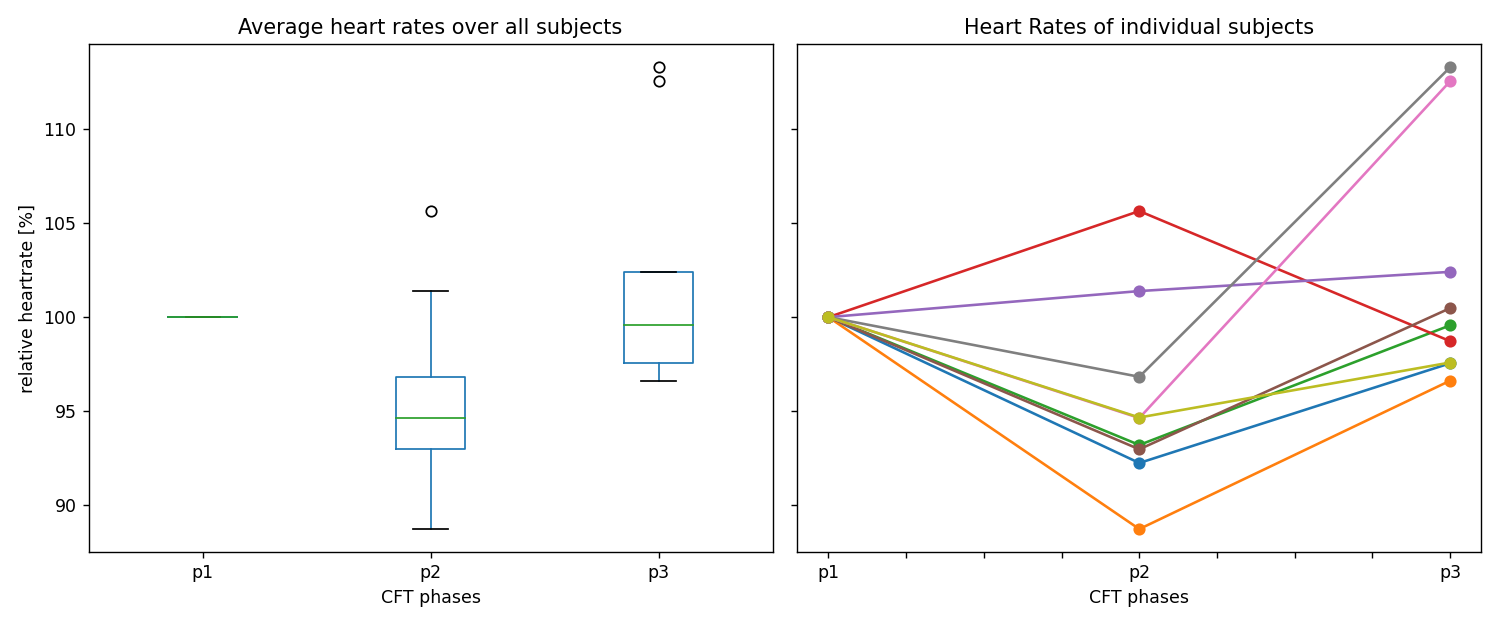

In [12]:
# Calculate the relative heartrate and visualize the results
### BEGIN SOLUTION
rel_heart_rate = all_heart_rates/all_heart_rates[0]
rates_df = pd.DataFrame(rel_heart_rate.T * 100)
rates_df.columns = ['p1', 'p2', 'p3']

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
rates_df.plot.box(ax=ax1)
ax1.set_title('Average heart rates over all subjects')
ax1.set_ylabel('relative heartrate [%]')
ax1.set_xlabel('CFT phases')

rates_df.T.plot.line(style='-o', legend=False, ax=ax2)
ax2.set_title('Heart Rates of individual subjects')
ax2.set_xlabel('CFT phases')

plt.tight_layout()
### END SOLUTION